# Query the Nemotron Parse API

This notebook demonstrates how to interact with the NVIDIA Nemotron Parse API using Python. 
It covers launching the NIM container, sending a request with an image, and visualizing the detected bounding boxes.

Reference: [NVIDIA Docs](https://docs.nvidia.com/nim/vision-language-models/latest/examples/nemotron-parse/api.html)

## 1. Launch NIM

Before running the Python code, you need to launch the Nemotron Parse NIM container. 
Run the following command in your terminal (ensure you have `ngc` configured and Docker installed):

```bash
# Choose a container name for bookkeeping 
export NGC_API_KEY="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"
export CONTAINER_NAME="nvidia-nemotron-parse" 
# The container name from the previous ngc registry image list command 
Repository="nemotron-parse"
Latest_Tag="1.5.0"

# Choose a VLM NIM Image from NGC 
export IMG_NAME="nvcr.io/nim/nvidia/${Repository}:${Latest_Tag}" 

# Choose a path on your system to cache the downloaded models 
export LOCAL_NIM_CACHE=~/.cache/nim 
mkdir -p "$LOCAL_NIM_CACHE" 

# Start the VLM NIM 
docker run -it --rm --name=$CONTAINER_NAME \
  --runtime=nvidia \
  --gpus all \
  --shm-size=16GB \
  -e NGC_API_KEY=$NGC_API_KEY \
  -v "$LOCAL_NIM_CACHE:/opt/nim/.cache" \
  -u $(id -u) \
  -p 8000:8000 \
  $IMG_NAME
```

## 2. Install Dependencies

In [ ]:
!pip install openai pillow requests

## 3. Query the API

We will send a request to the local API endpoint. We'll use an example image URL.

In [1]:
import json
import requests
from openai import OpenAI

# Initialize client
client = OpenAI(
    base_url="http://0.0.0.0:8000/v1",
    # For local deployment, an API key is not needed but must be non-empty
    api_key="dummy-key"
)

# Example Image URL from docs
image_url = "https://raw.githubusercontent.com/vis-nlp/ChartQA/main/ChartQA%20Dataset/val/png/5090.png"

completion = client.chat.completions.create(
    model="nvidia/nemotron-parse",
    # See Tool types section for more information.
    tools=[{"type": "function", "function": {"name": "markdown_bbox"}}],
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": image_url
                    },
                },
            ]
        }
    ],
    temperature=0.0,
)

tool_call = completion.choices[0].message.tool_calls[0]
results_of_detection = json.loads(tool_call.function.arguments)[0]

print("Detection Results:")
print(json.dumps(results_of_detection, indent=2))

Detection Results:
[
  {
    "bbox": {
      "xmin": -0.00021093247588430111,
      "ymin": 0.024846861924686197,
      "xmax": 0.8894971061093251,
      "ymax": 0.108394979079498
    },
    "text": "Many support government economic assistance",
    "type": "Title"
  },
  {
    "bbox": {
      "xmin": -0.00021093247588430111,
      "ymin": 0.1216769874476988,
      "xmax": 0.9467266881028936,
      "ymax": 0.24892719665271973
    },
    "text": "_It is the individual\u2019s responsibility to earn a decent standard of living OR it is the government\u2019s responsibility to ensure a decent standard of living for all?_",
    "type": "Text"
  },
  {
    "bbox": {
      "xmin": -0.00021093247588430111,
      "ymin": 0.898460251046025,
      "xmax": 0.9880591639871381,
      "ymax": 0.9520167364016738
    },
    "text": "Source: Survey of eight Western European countries conducted Oct. 30-Dec. 20, 2017.",
    "type": "Text"
  },
  {
    "bbox": {
      "xmin": -0.00021093247588430111,
      

## 4. Visualize Results

We will now visualize the bounding boxes on the image.

Saved visualization to example_result.png


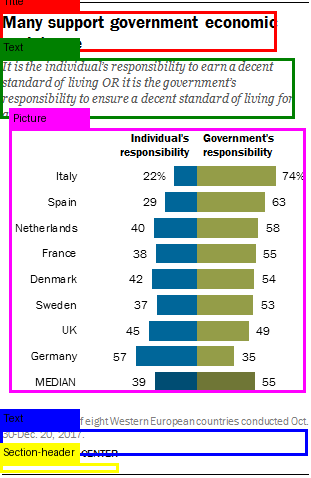

In [3]:
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO

# Download the image for visualization
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))
image.save("example.png") # Save locally as the script expects, or use object directly

# --- Start of NVIDIA Visualization Script ---

detections = results_of_detection

# Reload image to follow script exactly, or use 'image' object directly
# image = Image.open("example.png") 
draw = ImageDraw.Draw(image)
width, height = image.size

colors = ["red", "green", "blue", "yellow", "magenta", "cyan", "orange", "purple"]

try:
    font = ImageFont.truetype("arial.ttf", 16)
except IOError:
    font = ImageFont.load_default()

for i, det in enumerate(detections):
    bbox = det["bbox"]
    # Convert normalized coordinates to pixel values.
    left = bbox["xmin"] * width
    top = bbox["ymin"] * height
    right = bbox["xmax"] * width
    bottom = bbox["ymax"] * height

    # Choose a color for the box.
    color = colors[i % len(colors)]

    # Draw the bounding box with a 3-pixel thick outline.
    draw.rectangle([left, top, right, bottom], outline=color, width=3)

    # Use the 'type' key as the label title.
    label = det.get("type", "")

    # Instead of measuring text size, use a fixed-size background.
    fixed_label_width = 80  # Fixed width for the label background
    fixed_label_height = 20  # Fixed height for the label background

    # Draw a filled rectangle above the bounding box for the label background.
    draw.rectangle([left, top - fixed_label_height, left + fixed_label_width, top], fill=color)

    # Draw the label text (with a small padding).
    draw.text((left + 3, top - fixed_label_height + 3), label, fill="black", font=font)

image.save("example_result.png")
print("Saved visualization to example_result.png")

# Display the image in notebook
image
